# Gathering SED and HR 

The collects the SED from the the Scene Modeling Photometry of SDSS SN Ia host galaxies, Holtzman et al. (2008, [`arXiv:0908.4277`](https://arxiv.org/abs/0908.4277)) and Hubble Residuals from the ~1000 SN Ia from Campbell (2013), `data/SDSS_Photometric_SNe_Ia.fits`.

In [28]:
import re
import warnings

import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(np.__version__,
      pd.__version__
)

1.13.3 0.21.1


## define useful functions

In [12]:
def readMagnitudes(dataFile):
    """
    This reads and returns the mangitudes from an SDSS SMP data file
    
    # Parameters
    dataFile : str
        The name of the SMP data file. Include any needed file paths.
        
    # Returns
    magnitudes : np.array
        A structured array made some stupid repeating BS. So it got tossed. 
        The aruments come out in [u, u uncert, g, g uncert, r, r uncert, 
        i, i uncert, z, z uncert] order.
    """
    with open(dataFile, 'r') as f:
        f.readline()
        secondLine = f.readline()
        thirdLine = f.readline()
    
    asinhmag = False
    if asinhmag:
        dataLine = secondLine
    else:
        dataLine = thirdLine
        
    #clean up data line and extract desired info
    split = np.array( re.split(r'\s+', dataLine) )     #split on whitespace
    #the index of the g (r) values are 3 (4) spaces over from the first '='
    index = np.arange(5)+ 5       #(np.where(split == '=')[0]+3)
    SB = split[index].astype(float)
    
    if any(SB < 0):
        #send warning if we got a negative flux! But still out put the data as is.
        warnings.warn(r'{} has a negative flux: u,g,r,i,z = {} μJy/sqr-arcsec'.format(dataFile, SB))
        #todo(fix warning so that it outputs the correct units depending on any `asinhmag`)
#         magnitudes = np.nan*np.ones(10)

    uncertIndex = index + 8
    uncert = split[uncertIndex].astype(float)

    if not asinhmag:
        # or could be 1.0857*uncertG/gSB
        # SB needs to be in flux units for uncert calculation
        uncert = uncert*np.abs(2.5/(SB*np.log(10)))
        SB = -2.5*np.log10(SB*1e-6/3631)

    #combine as [value, uncert, ...], and save as a structured array
    magnitudes = np.array(np.stack((SB, uncert), axis=1).flatten(),) 
    
    return magnitudes

## get Campbell Data

In [51]:
t = Table.read('SDSS_Photometric_SNe_Ia.fits')
t.info

<Table length=752>
   name     dtype 
---------- -------
       CID   int32
         Z float32
     Z_ERR float32
     SN_RA float32
    SN_DEC float32
    GAL_RA float32
   GAL_DEC float32
HOST_OBJID   int64
        X0 float32
    X0_ERR float32
        X1 float32
    X1_ERR float32
     COLOR float32
 COLOR_ERR float32
       C01 float32
       C00 float32
       C11 float32
       C22 float32
       C02 float32
       C12 float32
        MU float32
     MU_MB float32
    MU_ERR float32

In [52]:
SNData = t[['CID','Z', 'Z_ERR', 'MU', 'MU_ERR']]
SNData = SNData.to_pandas()
SNData.rename(str.lower, axis='columns', inplace=True)   # pandas > 0.19.0 needed, 0.21.1 works something inbetween might also work
SNData.rename(columns={"z": "redshift", "z_err": "err_redshift", "mu_err": "err_mu"}, inplace=True)
SNData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752 entries, 0 to 751
Data columns (total 5 columns):
cid             752 non-null int32
redshift        752 non-null float32
err_redshift    752 non-null float32
mu              752 non-null float32
err_mu          752 non-null float32
dtypes: float32(4), int32(1)
memory usage: 14.8 KB


## Get Holtzman Data

In [53]:
# add columns for [u, u uncert, g, g uncert, r, r uncert, i, i uncert, z, z uncert] 
SNData['u'] = np.nan
SNData['g'] = np.nan
SNData['r'] = np.nan
SNData['i'] = np.nan
SNData['z'] = np.nan
SNData['err_u'] = np.nan
SNData['err_g'] = np.nan
SNData['err_r'] = np.nan
SNData['err_i'] = np.nan
SNData['err_z'] = np.nan

SNData.head()

,cid,redshift,err_redshift,mu,err_mu,u,g,r,i,z,err_u,err_g,err_r,err_i,err_z
0,10028,0.065392,0.000009,37.020199,0.090201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10037,0.253816,0.000049,40.307499,0.200429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1032,0.129755,0.000034,38.660999,0.124407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10324,0.251725,0.000031,40.097198,0.151389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10434,0.104161,0.000020,38.437698,0.069367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
dataFile = 'SMP-photometry/SMP_{}.dat'    #need to add a s6, error padded integer

for i, CID in enumerate(SNData['cid']):
    CID = str(int(CID)).zfill(6)
    magitudes = readMagnitudes(dataFile.format(CID))
    SNData.loc[i, ['u', 'err_u', 'g', 'err_g', 'r', 'err_r', 'i', 'err_i', 'z', 'err_z']] = magitudes
    
SNData.head()

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:34: UserWarning: SMP-photometry/SMP_010449.dat has a negative flux: u,g,r,i,z = [-0.1736  0.6237  1.192   1.431   2.007 ] μJy/sqr-arcsec
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:34: UserWarning: SMP-photometry/SMP_012213.dat has a negative flux: u,g,r,i,z = [-0.305    0.02695 -0.01997 -0.01652  0.5137 ] μJy/sqr-arcsec
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:34: UserWarning: SMP-photometry/SMP_012978.dat has a negative flux: u,g,r,i,z = [ 0.558   0.1314 -0.132   0.1893  0.8563] μJy/sqr-arcsec
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:34: UserWarning: SMP-photometry/SMP_013497.dat has a negative flux: u,g,r,i,z = [-0.04794  0.3317   1.674    2.504    3.813  ] μJy/sqr-arcsec
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:34: UserWarning: SMP-

,cid,redshift,err_redshift,mu,err_mu,u,g,r,i,z,err_u,err_g,err_r,err_i,err_z
0,10028,0.065392,0.000009,37.020199,0.090201,21.223124,19.453783,18.640556,18.274016,17.984475,0.041225,0.003414,0.001934,0.001704,0.003943
1,10037,0.253816,0.000049,40.307499,0.200429,25.210888,22.281608,20.957668,20.318043,19.900631,1.528746,0.034431,0.014845,0.011875,0.030861
2,1032,0.129755,0.000034,38.660999,0.124407,24.920457,24.743643,23.730529,23.320755,22.865978,0.611091,0.161373,0.098543,0.117234,0.265821
3,10324,0.251725,0.000031,40.097198,0.151389,24.617600,23.986003,23.127588,22.811649,22.450892,0.601528,0.107845,0.061509,0.067097,0.177679
4,10434,0.104161,0.000020,38.437698,0.069367,26.603156,24.483290,23.559057,23.189553,22.810853,6.176156,0.194890,0.092315,0.092886,0.287300


## Check & Clean the data

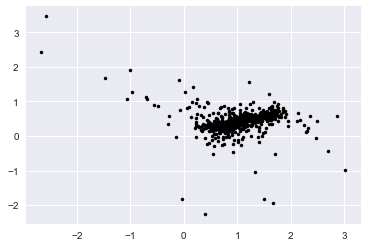

In [55]:
plt.figure('g-r vs r-i')
plt.plot(SNData['g']-SNData['r'], SNData['r']-SNData['i'], 'k.')

In [56]:
SNData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752 entries, 0 to 751
Data columns (total 15 columns):
cid             752 non-null int32
redshift        752 non-null float32
err_redshift    752 non-null float32
mu              752 non-null float32
err_mu          752 non-null float32
u               631 non-null float64
g               739 non-null float64
r               741 non-null float64
i               741 non-null float64
z               731 non-null float64
err_u           742 non-null float64
err_g           752 non-null float64
err_r           752 non-null float64
err_i           752 non-null float64
err_z           752 non-null float64
dtypes: float32(4), float64(10), int32(1)
memory usage: 73.5 KB


In [57]:
SNData.dropna().describe()

,cid,redshift,err_redshift,mu,err_mu,u,g,r,i,z,err_u,err_g,err_r,err_i,err_z
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,13201.724541,0.288016,0.000149,40.535587,0.159802,24.649170,23.674372,22.632422,22.203541,21.854990,1.739358,0.145710,0.082921,0.071105,0.259040
std,6074.344949,0.103436,0.000993,1.059342,0.070819,1.225497,1.247607,1.312859,1.340931,1.367404,6.144403,0.263336,0.214654,0.135809,0.958629
min,703.000000,0.045248,0.000006,36.166698,0.056201,21.223124,19.453783,18.640556,18.274016,17.984475,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7558.500000,0.214415,0.000021,39.960300,0.102185,23.838344,22.870812,21.746604,21.226821,20.821714,0.316161,0.032718,0.015410,0.013360,0.035421
50%,15203.000000,0.289763,0.000035,40.669601,0.154637,24.494120,23.614372,22.528785,22.097808,21.748921,0.590078,0.064741,0.031590,0.028456,0.079166
75%,18368.500000,0.364398,0.000064,41.306299,0.207190,25.250273,24.421554,23.525872,23.102301,22.764861,1.338685,0.152651,0.079217,0.073064,0.220414
max,22075.000000,0.700345,0.010000,42.528500,0.507654,30.167118,27.983541,27.689672,26.213939,27.456911,100.935451,3.758066,3.536744,2.097445,14.854871


In [71]:
# drop NA
SNData = SNData.dropna()
# Remove mag uncertany of > 1.5 mags
cut = 1.5
SNData = SNData[SNData['err_u']<cut]
SNData = SNData[SNData['err_g']<cut]
SNData = SNData[SNData['err_r']<cut]
SNData = SNData[SNData['err_i']<cut]
SNData = SNData[SNData['err_z']<cut]
# Remove no uncertainty
SNData = SNData[SNData['err_u']!=0]
# g, r, i, z is not needed since if there is no uncertainty in one filter
# there appears to be no uncertainty in any filter.


SNData.describe()

,cid,redshift,err_redshift,mu,err_mu,u,g,r,i,z,err_u,err_g,err_r,err_i,err_z
count,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000
mean,13050.007042,0.272759,0.000113,40.394623,0.150447,24.133785,23.387497,22.383159,21.976391,21.623501,0.555055,0.102386,0.056455,0.054879,0.143656
std,6100.853381,0.101911,0.000834,1.100113,0.070013,0.765331,1.151460,1.199622,1.255953,1.226138,0.345096,0.144491,0.099152,0.091048,0.192210
min,703.000000,0.045248,0.000006,36.166698,0.056201,21.223124,19.453783,18.640556,18.274016,17.984475,0.039937,0.003414,0.001934,0.001704,0.003943
25%,7390.750000,0.197472,0.000019,39.797899,0.090380,23.641627,22.631864,21.579004,21.095141,20.750186,0.291846,0.030901,0.014925,0.013212,0.035247
50%,15031.500000,0.277635,0.000030,40.572350,0.137224,24.195185,23.322029,22.309225,21.935496,21.597867,0.491008,0.057930,0.027691,0.025177,0.072656
75%,18356.250000,0.345759,0.000055,41.174451,0.194748,24.651509,24.143363,23.105431,22.764862,22.412428,0.732652,0.114693,0.055962,0.057656,0.157108
max,22075.000000,0.568893,0.010000,42.485298,0.464160,25.818210,26.795260,26.402457,26.213939,24.852854,1.494077,1.353225,1.062840,1.044575,1.490733


#### Remove higher redshfits as if the "local" enviorment is not local

SDSS has a [seeing of 1.43"](http://classic.sdss.org/dr7/products/general/seeing.html). This is 6.933×10^-6 radians. Using the [small angle formula](http://astro.physics.uiowa.edu/ITU/glossary/small-angle-formula/) we have:
$$d = \theta \times D.$$
Converting to redshift of the object rather then distance to the object we get:
$$d = \dfrac{\theta~c~z}{H_{0}}.$$
Though this answer will get d interms of Mpcs.


What redshift limit gives us a 10 kpc maximum restframe resolution limit?
$$z = \dfrac{H_{0}~d}{\theta~c}$$
$$$$
$$z = \dfrac{70~\text{km/s/Mpc} \times 0.01~\text{Mpc}}{6.933×10^{-6} \times 3x10^5~\text{km/s}}$$
$$$$
[$$z = 0.337$$][results]

[results]: https://www.wolframalpha.com/input/?i=(70*0.01)%2F(6.933e-6*3e5) "results"


In [72]:
SNData = SNData[SNData['redshift']<0.337]
SNData.describe()

,cid,redshift,err_redshift,mu,err_mu,u,g,r,i,z,err_u,err_g,err_r,err_i,err_z
count,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000
mean,13045.771242,0.224145,0.000099,39.948662,0.122232,24.011113,23.168795,22.239489,21.855263,21.524422,0.512292,0.089840,0.051601,0.053748,0.136492
std,6043.361189,0.071996,0.000805,0.962374,0.051352,0.780598,1.171936,1.228850,1.300597,1.264969,0.331822,0.136142,0.090489,0.099032,0.176065
min,703.000000,0.045248,0.000006,36.166698,0.056201,21.223124,19.453783,18.640556,18.274016,17.984475,0.039937,0.003414,0.001934,0.001704,0.003943
25%,7144.000000,0.175553,0.000016,39.452576,0.081528,23.504362,22.376099,21.393843,20.954427,20.625598,0.264121,0.027622,0.012440,0.011172,0.030886
50%,15132.500000,0.236589,0.000027,40.184900,0.113418,24.063001,23.069476,22.162786,21.861956,21.550396,0.434057,0.045071,0.024062,0.024450,0.071151
75%,18280.500000,0.285358,0.000040,40.662149,0.151589,24.559576,23.852281,23.032255,22.694615,22.366340,0.677718,0.091553,0.052039,0.054295,0.150086
max,22075.000000,0.336029,0.010000,41.312099,0.383651,25.591935,26.795260,25.981772,26.213939,24.504300,1.470127,1.353225,1.062840,1.044575,1.076265


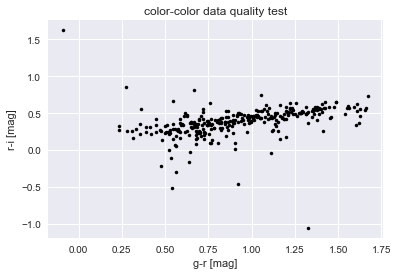

In [73]:
plt.figure('g-r vs r-i')
plt.plot(SNData['g']-SNData['r'], SNData['r']-SNData['i'], 'k.')
plt.xlabel('g-r [mag]')
plt.ylabel('r-i [mag]')
plt.title('color-color data quality test')

## save the data

In [74]:
SNData.to_csv('local_SN.tsv', sep='\t', index=False)